In [130]:
options(warn=-1)

library(data.table)
library(data.table)
library(tidyverse)
library(bupaR)
library(edeaR)
library(processmapR)

# data
load('olist_eventlog.RData')
eventlog <- as.data.table(event_log)
eventlog[, activity := as.character(activity)]

# data for regression
dataRegression <- copy(eventlog)

## 4 Satisfaction Analysis

Idea: Create "duration"-variables, ie the time passed between two activities. But only for activities that can be observed by the customer.

* time passed between **purchase** and **approval** (does the customer care about approval? Or only delivery?)
* time passed between **approval** and **delivery** (does the customer care about approval? Or only delivery?)
* time passed between **purchase** and **delivery** 
* time passed between **product delivered** and **review provided** (Do mad customers provide quicker reviews?)

In [68]:
# A function that takes in an eventlog-dataset and creates a column with the 
# duration (in days) between the two specified activities.
CreateDurationVariable <- function(dat, fromActivity, toActivity, colname){
  data <- copy(dat)
  
  data[, fromActivityTimestamp := min(timestamp), by = .(order_id)]
  data[activity == fromActivity, fromActivityTimestamp := timestamp, by = .(order_id)]
  data[, fromActivityTimestamp := max(fromActivityTimestamp), by = .(order_id)]

  data[, toActivityTimestamp := min(timestamp), by = .(order_id)]
  data[activity == toActivity, toActivityTimestamp := timestamp, by = .(order_id)]
  data[, toActivityTimestamp := max(toActivityTimestamp), by = .(order_id)]
  
  data[, newDurationVariable := rep(0, length.out = nrow(data))]
  data[, newDurationVariable := as.numeric(
    difftime(toActivityTimestamp, fromActivityTimestamp, units = "days"))]
  
  data[, ':='(fromActivityTimestamp = NULL,
              toActivityTimestamp = NULL)]
  
  setnames(data, old="newDurationVariable", new=colname)
  return(data)
}

#### Create duration variables

In [69]:
# Create variable for the duration between purchase and delivery (to customer)
dataRegression <- CreateDurationVariable(
  dat = dataRegression,
  fromActivity = "purchase",
  toActivity = "deliever_customer",
  colname = "durPurchaseToDelivery"
)

# Create variable for the duration between purchase and approval
dataRegression <- CreateDurationVariable(
  dat = dataRegression,
  fromActivity = "purchase",
  toActivity = "approve",
  colname = "durPurchaseToApproval"
)

# Create variable for the duration between approval and delivery
dataRegression <- CreateDurationVariable(
  dat = dataRegression,
  fromActivity = "approve",
  toActivity = "deliever_customer",
  colname = "durApprovalToDelivery"
)

# Create variable for the duration between approval and delivery
dataRegression <- CreateDurationVariable(
  dat = dataRegression,
  fromActivity = "deliever_customer",
  toActivity = "customer provides review",
  colname = "durDeliveryToReview"
)

#### Remove variables that are irrelevant for regression (e.g. ID-Variables)

In [157]:
# Remove variables that are non-relevant for regression 
dataRegression <- dataRegression %>% 
  select(-starts_with("max"),
         -ends_with("date"),
         -c("activity_instance",
            "status",
            "timestamp",
            ".order",
            "activity",
            "customer_state")) %>% 
  setDT()

# Retain a single row for each case (Before, for each order there were several rows)
dataRegression <- dataRegression[!duplicated(dataRegression$order_id)]

# Further remove non-relevant variables
dataRegression <- dataRegression %>% select(-ends_with("id"))

In [158]:
colnames(dataRegression)

[1] "review_score"       "boleto"             "credit_card"       
 [4] "debit_card"         "nmb_pay_types"      "not_defined"       
 [7] "total_installments" "total_pay_value"    "voucher"           
[10] "nmb_items"          "unique_items"       "nmb_sellers"       
[13] "sum_items_value"    "nmb_categories"     "avg_desc_length"   
[16] "avg_ph_quality"

#### Check for correlations between the duration-variables

In [72]:
durationVars <- dataRegression %>% select(starts_with("dur"))

head(durationVars, 3)

durPurchaseToDelivery,durPurchaseToApproval,durApprovalToDelivery,durDeliveryToReview
<dbl>,<dbl>,<dbl>,<dbl>
6.842280,0.01626157,6.826019,3.754086
3.793993,0.01346065,3.780532,1.153044
17.939583,0.01017361,17.929410,1.685995


In [73]:
# Are there any NAs?
rbindlist(lapply(colnames(durationVars), function(colname){
    x <- durationVars[, get(colname)]
    countNAs <- sum(is.na(x))
    return(data.table(col = colname, countNAs = countNAs))
}))

col,countNAs
<chr>,<int>
durPurchaseToDelivery,6
durPurchaseToApproval,6
durApprovalToDelivery,6
durDeliveryToReview,6


In [74]:
# Remove NAs
print(nrow(durationVars))
durationVars <- na.omit(durationVars)
print(nrow(durationVars))

[1] 24120
[1] 24114


In [75]:
round(cor(durationVars), 3)

,durPurchaseToDelivery,durPurchaseToApproval,durApprovalToDelivery,durDeliveryToReview
durPurchaseToDelivery,1.000,0.080,0.996,-0.274
durPurchaseToApproval,0.080,1.000,-0.012,0.010
durApprovalToDelivery,0.996,-0.012,1.000,-0.275
durDeliveryToReview,-0.274,0.010,-0.275,1.000


* `Approval-To-Delivery` and `Purchase-To-Delivery` have almost perfect correlation.
* $\Rightarrow$ Drop `Approval-To-Delivery` and run regression

In [76]:
dataRegression <- dataRegression %>% select(-durApprovalToDelivery)

### Regression

In [77]:
simpleLinearModel <- lm(review_score ~ ., dataRegression)
summary(simpleLinearModel)


Call:
lm(formula = review_score ~ ., data = dataRegression)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.8823 -0.4371  0.4832  0.7396  9.0960 

Coefficients: (2 not defined because of singularities)
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)            6.132e+00  1.263e-01  48.550  < 2e-16 ***
boleto                 5.471e-02  6.738e-02   0.812   0.4168    
credit_card           -1.808e-02  6.506e-02  -0.278   0.7811    
debit_card            -4.939e-02  9.002e-02  -0.549   0.5833    
nmb_pay_types          3.098e-02  5.360e-02   0.578   0.5632    
not_defined                   NA         NA      NA       NA    
total_installments     4.643e-03  3.293e-03   1.410   0.1585    
total_pay_value        1.927e-03  4.587e-04   4.201 2.67e-05 ***
voucher                       NA         NA      NA       NA    
nmb_items             -2.678e-01  1.836e-02 -14.587  < 2e-16 ***
unique_items          -3.671e-03  4.722e-02  -0.078   0.9380    
nmb_selle

* `nmb_items` has a signficant negative coefficient
    - As you order more items, the order might take longer
    - $\Rightarrow$ Does nmb_items correlate with `durPurchaseToDelivery`?
* `total_pay_value` has a significant positive coefficient
    - Maybe customers who have already ordered at OLIST tend to order larger volumes. But since they have already ordered, they must have been already satisfied before ("self-selection")
* **Duration between purchase and delivery** has a significant negative relationship with the review-score:
    - As the duration takes 1 day longer, you expect a review with 0.045 less stars.
* **Duration between delivery and review** has a significant positive relationship with the review-score:
    - Unsatisfied customers are quicker with their reviews, as they want to express their rage immediatly (?)
 

In [78]:
cor(dataRegression$nmb_items, dataRegression$durPurchaseToDelivery, use = "complete.obs")

[1] -0.02045544

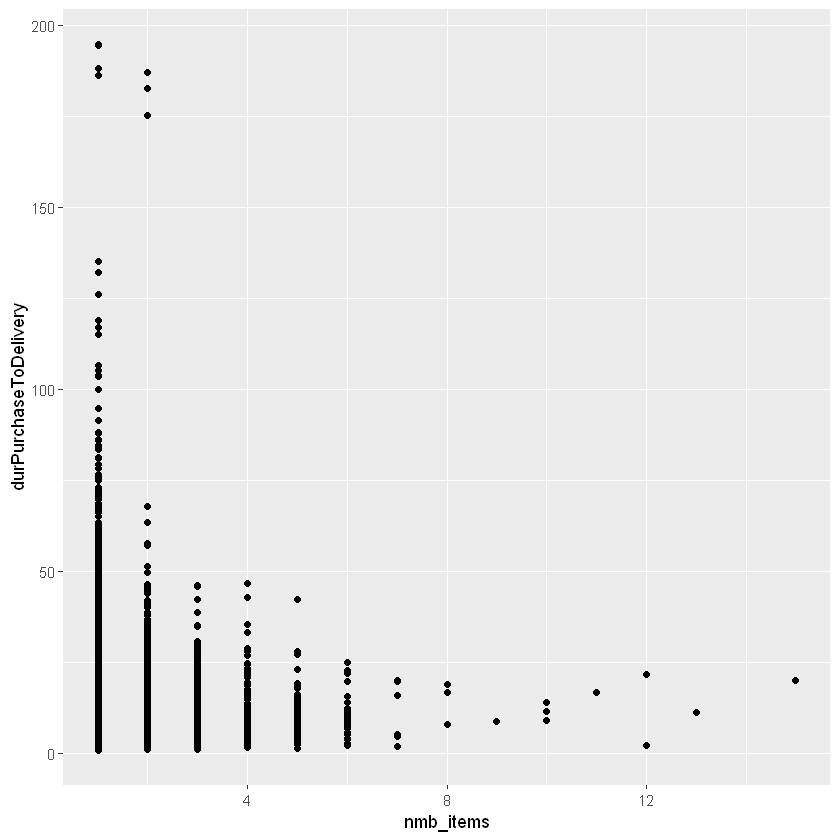

In [79]:
ggplot(dataRegression, aes(x = nmb_items, y = durPurchaseToDelivery)) +
    geom_point()